In [1]:
import torch
import detectron2

# Get PyTorch version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
print("torch: ", TORCH_VERSION)

# Get Detectron2 version
print("detectron2:", detectron2.__version__)

torch:  2.3
detectron2: 0.6


In [2]:
import pandas as pd
import numpy as np

In [3]:
import json
from collections import defaultdict

# Step 1: Load your JSON file
with open('net_data/train_dataset/train.json') as f:
    data = json.load(f)

# Initialize counters for each class
class_counts = defaultdict(int)

# Step 2: Count instances of each category
for instance in data['annotations']:
    category_id = instance['category_id']
    class_counts[category_id] += 1

# Calculate total number of instances
total_instances = sum(class_counts.values())

# Step 3: Calculate class weights
class_weights = {category_id: total_instances / (len(class_counts) * count) for category_id, count in class_counts.items()}

# Print the class weights
print("Class Weights:", class_weights)


# class weights are saved in json file 
with open('class_weights.json', 'w') as f:
    json.dump(class_weights, f, indent=2)

print("Class weights calculated successfully.")


Class Weights: {1: 1.4357638888888888, 2: 0.7671614100185529}
Class weights calculated successfully.


In [4]:
import os
import torch
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
import cv2

# Register your dataset
register_coco_instances("dataset_dicts", {}, 
    "net_data/train_dataset/train.json", 
    "net_data/train_dataset")
register_coco_instances("my_dataset_val", {}, 
    "net_data/validation_dataset/val.json", 
    "net_data/validation_dataset")

# Define class weights
class_weights = {0: 1.4357638888888888, 1: 0.7671614100185529}

# Setup the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_dicts",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000  # Increase the number of iterations for better training
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_weights)  # Update with the number of classes

# Data loader settings for class balancing
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 2.0  # Ensure this is a float

# Use CPU
cfg.MODEL.DEVICE = "cpu"

# Output directory, if you are retraining model delete the content of this folder before training
cfg.OUTPUT_DIR = "net_data/output_results"

# Create output directory if it doesn't exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Save the configuration to a yaml file
config_yaml_path = os.path.join(cfg.OUTPUT_DIR, "config.yaml")
with open(config_yaml_path, 'w') as file:
    file.write(cfg.dump())

# Define a custom trainer to add evaluator
class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, False, output_dir=cfg.OUTPUT_DIR)

# Train the model
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Prediction
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2

# Load the configuration and trained model
cfg = get_cfg()
cfg.merge_from_file(config_yaml_path)  # Path to your saved config.yaml file
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Path to your trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )

# Use CPU for prediction
cfg.MODEL.DEVICE = "cpu"

# Initialize the predictor
predictor = DefaultPredictor(cfg)

# Predict for the entire validation dataset
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")
metadata = MetadataCatalog.get("my_dataset_val")

output_results_dir = os.path.join(cfg.OUTPUT_DIR, "predictions")
os.makedirs(output_results_dir, exist_ok=True)

# Prepare CSV file
import csv
csv_file_path = os.path.join(output_results_dir, "predictions.csv")
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['file_name', 'class_id', 'class_name', 'score', 'bbox']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    for d in val_dataset_dicts:
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes if instances.has("pred_boxes") else None
        scores = instances.scores if instances.has("scores") else None
        classes = instances.pred_classes if instances.has("pred_classes") else None
        
        for i in range(len(instances)):
            bbox = boxes[i].tensor.numpy().tolist()[0] if boxes is not None else []
            score = scores[i].item() if scores is not None else 0
            class_id = classes[i].item() if classes is not None else -1
            class_name = metadata.thing_classes[class_id] if class_id != -1 else "unknown"
            
            # Write the prediction to the CSV file
            writer.writerow({
                'file_name': os.path.basename(d["file_name"]),  # Save only the file name
                'class_id': class_id,
                'class_name': class_name,
                'score': score,
                'bbox': bbox
            })

        # Visualize the predictions and save the image with the original file name
        v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
        out = v.draw_instance_predictions(instances)
        result_image_path = os.path.join(output_results_dir, os.path.basename(d["file_name"]))
        cv2.imwrite(result_image_path, out.get_image()[:, :, ::-1])
        print(f"Saved {result_image_path}")

print(f"Predictions saved to {csv_file_path}")

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Group by 'file_name' and 'class_name', and count occurrences
counts_per_category = df.groupby(['file_name', 'class_name']).size().reset_index(name='count')

import os
import pandas as pd

# Pivot the table to have 'file_name' as rows, 'class_name' as columns, and 'count' as values
counts_pivot = counts_per_category.pivot(index='file_name', columns='class_name', values='count').fillna(0)

# Sort the pivoted counts DataFrame by 'file_name' alphabetically
counts_pivot_sorted = counts_pivot.sort_index()

# Convert all values in the DataFrame to integers
counts_pivot_sorted = counts_pivot_sorted.astype(int)

# Save the counts per category for each file name to a CSV file
output_results_dir = "net_data/output_results/predictions"
counts_pivot_csv_path = os.path.join(output_results_dir, "counts_per_category_per_file.csv")
counts_pivot_sorted.to_csv(counts_pivot_csv_path)

print(f"Counts per category per file saved to {counts_pivot_csv_path}")


[06/27 16:52:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/27 16:52:51 d2.engine.train_loop]: Starting training from iteration 0


/Users/dk/Desktop/complete_detectron_/.detectron2-env/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/27 16:54:26 d2.utils.events]:  eta: 1:13:17  iter: 19  total_loss: 2.575  loss_cls: 1.115  loss_box_reg: 0.7503  loss_rpn_cls: 0.5218  loss_rpn_loc: 0.1215    time: 4.5780  last_time: 5.7941  data_time: 0.0687  last_data_time: 0.0011   lr: 4.9953e-06  
[06/27 16:57:08 d2.utils.events]:  eta: 1:36:11  iter: 39  total_loss: 2.409  loss_cls: 1.045  loss_box_reg: 0.7938  loss_rpn_cls: 0.4502  loss_rpn_loc: 0.1286    time: 6.4047  last_time: 5.8792  data_time: 0.0027  last_data_time: 0.0033   lr: 9.9902e-06  
[06/27 17:00:02 d2.utils.events]:  eta: 1:57:51  iter: 59  total_loss: 2.075  loss_cls: 0.9275  loss_box_reg: 0.8226  loss_rpn_cls: 0.1952  loss_rpn_loc: 0.089    time: 7.1971  last_time: 10.1143  data_time: 0.0036  last_data_time: 0.0024   lr: 1.4985e-05  
[06/27 17:02:51 d2.utils.events]:  eta: 1:58:38  iter: 79  total_loss: 1.765  loss_cls: 0.8022  loss_box_reg: 0.7658  loss_rpn_cls: 0.06735  loss_rpn_loc: 0.08514    time: 7.5187  last_time: 8.7926  data_time: 0.0042  last_data_

In [5]:
import json
import csv
import pandas as pd

# Function to count instances per category per file
def count_instances_per_file(annotations, images):
    instances_per_file = {}

    for annotation in annotations:
        image_id = annotation['image_id']
        category_id = annotation['category_id']

        # Find the image file name corresponding to this image_id
        image_filename = None
        for image in images:
            if image['id'] == image_id:
                image_filename = image['file_name']
                break

        if image_filename is not None:
            # Initialize the count for this image file if it's not already in the dictionary
            if image_filename not in instances_per_file:
                instances_per_file[image_filename] = {'file_name': image_filename, 'NETs': 0, 'non-net': 0}

            # Count instances of each category in this image file
            if category_id == 1:
                instances_per_file[image_filename]['NETs'] += 1
            elif category_id == 2:
                instances_per_file[image_filename]['non-net'] += 1

    return instances_per_file

# Load the JSON file
json_file = "net_data/validation_dataset/val.json"  # Replace with your JSON file path
with open(json_file, 'r') as f:
    data = json.load(f)

# Extract annotations and images from data
annotations = data['annotations']
images = data['images']

# Count instances per category per file
instances_per_file = count_instances_per_file(annotations, images)

# Write results to a CSV file
csv_file = "net_data/validation_true_labels.csv"  # Replace with desired output CSV file path

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(instances_per_file, orient='index')

# Sort the DataFrame by 'file_name' column
df.sort_values(by='file_name', inplace=True)

# Ensure the columns are in the correct order
df = df[['file_name', 'NETs', 'non-net']]

# Write the sorted DataFrame to CSV with numerical values
df.to_csv(csv_file, index=False)

print(f"CSV file saved to: {csv_file}")



CSV file saved to: net_data/validation_true_labels.csv


In [6]:
! pip install scikit-learn

  Using cached scikit_learn-1.5.0-cp311-cp311-macosx_12_0_arm64.whl (11.0 MB)
  Using cached scipy-1.14.0-cp311-cp311-macosx_14_0_arm64.whl (23.1 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)

[notice] A new release of pip available: 22.3.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import confusion_matrix

df_ground_truth = pd.read_csv("/Users/dk/Desktop/complete_detectron_/net_data/validation_true_labels.csv")
df_predicted = pd.read_csv("net_data/output_results/predictions/counts_per_category_per_file.csv")

# Extract the counts for NETs and non-nets from the ground truth and predicted data
true_net = df_ground_truth['NETs'].tolist()
true_nonnet = df_ground_truth['non-net'].tolist()
predicted_net = df_predicted['NETs'].tolist()
predicted_nonnet = df_predicted['non-net'].tolist()


# Aggregate the total counts of NETs and nonNETs across all samples
total_actual_nets = sum(true_net)
total_actual_nonnets = sum(true_nonnet)
total_predicted_nets = sum(predicted_net )
total_predicted_nonnets = sum(predicted_nonnet)

print(total_actual_nets,total_actual_nonnets,total_predicted_nets,total_predicted_nonnets)

152 379 200 407


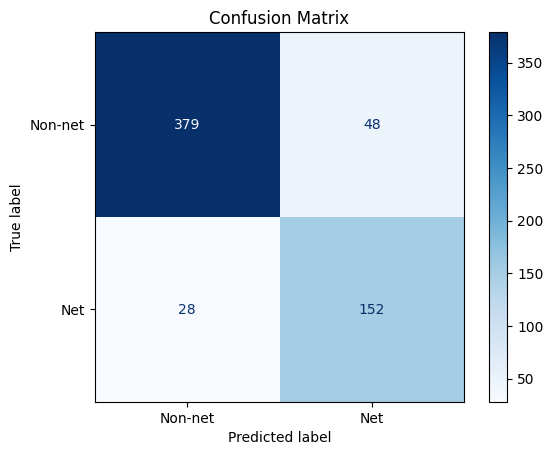

Classification Report:
              precision    recall  f1-score   support

     Non-net       0.93      0.89      0.91       427
         Net       0.76      0.84      0.80       180

    accuracy                           0.87       607
   macro avg       0.85      0.87      0.85       607
weighted avg       0.88      0.87      0.88       607



In [2]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Given data
true_net = 152
predicted_net = 200
true_nonnet = 379
predicted_nonnet = 407

# Calculate False Positives (FP) and False Negatives (FN)
fp = predicted_net - true_net
fn = predicted_nonnet - true_nonnet


# Ensure FN is non-negative (in practice, it should be zero or positive)
fn = max(fn, 0)

# Create arrays of true labels and predicted labels
# Assumption: total instances = TP + TN + FP + FN
true_labels = [1] * true_net + [0] * true_nonnet + [1] * fn + [0] * fp
predicted_labels = [1] * true_net + [0] * true_nonnet + [0] * fn + [1] * fp

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-net', 'Net'])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=['Non-net', 'Net'])
print("Classification Report:")
print(report)


In [9]:
import os
import cv2
import pandas as pd
import csv
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Paths to configuration and model weights
config_file_path = "net_data/output_results/config.yaml"
model_weights_path = "net_data/output_results/model_final.pth"
input_images_directory = "net_data/test_dataset"
output_directory = "net_data/output_results/predictions_test"

# Configuration setup
cfg = get_cfg()
cfg.merge_from_file(config_file_path)
cfg.MODEL.WEIGHTS = model_weights_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold

# Use CPU for prediction
cfg.MODEL.DEVICE = "cpu"

# Initialize the predictor
predictor = DefaultPredictor(cfg)

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Function to load test dataset
def load_my_test_dataset(dataset_path):
    dataset_dicts = []
    # Placeholder for dataset loading logic
    # Add your dataset loading logic here
    return dataset_dicts

# Register the test dataset
DatasetCatalog.register("dataset_test", lambda: load_my_test_dataset(input_images_directory))
MetadataCatalog.get("dataset_test").set(thing_classes=["NETs", "nonnet"])

# Metadata for the test dataset
metadata = MetadataCatalog.get("dataset_test")

# Prepare CSV file for saving predictions
csv_file_path = os.path.join(output_directory, "predictions.csv")
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['file_name', 'class_id', 'class_name', 'score', 'bbox']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        if image_filename.endswith(".tif"):
            image_path = os.path.join(input_images_directory, image_filename)
            im = cv2.imread(image_path)
            outputs = predictor(im)
            instances = outputs["instances"].to("cpu")
            boxes = instances.pred_boxes if instances.has("pred_boxes") else None
            scores = instances.scores if instances.has("scores") else None
            classes = instances.pred_classes if instances.has("pred_classes") else None

            for i in range(len(instances)):
                bbox = boxes[i].tensor.numpy().tolist()[0] if boxes is not None else []
                score = scores[i].item() if scores is not None else 0
                class_id = classes[i].item() if classes is not None else -1
                class_name = metadata.thing_classes[class_id] if class_id != -1 else "unknown"

                # Write the prediction to the CSV file
                writer.writerow({
                    'file_name': image_filename,  # Save only the file name
                    'class_id': class_id,
                    'class_name': class_name,
                    'score': score,
                    'bbox': bbox
                })

            # Visualize the predictions and save the image with the original file name
            v = Visualizer(im[:, :, ::-1], metadata, scale=1.2)
            out = v.draw_instance_predictions(instances)
            result_image_path = os.path.join(output_directory, os.path.splitext(image_filename)[0] + "_result.png")
            cv2.imwrite(result_image_path, out.get_image()[:, :, ::-1])
            print(f"Saved {result_image_path}")

print(f"Predictions saved to {csv_file_path}")

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Group by 'file_name' and 'class_name', and count occurrences
counts_per_category = df.groupby(['file_name', 'class_name']).size().reset_index(name='count')

# Pivot the table to have 'file_name' as rows, 'class_name' as columns, and 'count' as values
counts_pivot = counts_per_category.pivot(index='file_name', columns='class_name', values='count').fillna(0)

# Sort the pivoted counts DataFrame by 'file_name' alphabetically
counts_pivot_sorted = counts_pivot.sort_index()

# Convert all values in the DataFrame to integers
counts_pivot_sorted = counts_pivot_sorted.astype(int)

# Save the counts per category for each file name to a CSV file
counts_pivot_csv_path = os.path.join(output_directory, "counts_per_category_per_file.csv")
counts_pivot_sorted.to_csv(counts_pivot_csv_path)

print(f"Counts per category per file saved to {counts_pivot_csv_path}")

print("Segmentation of all images completed.")


/Users/dk/Desktop/complete_detectron_/.detectron2-env/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Saved net_data/output_results/predictions_test/Ctrl_2_result.png
Saved net_data/output_results/predictions_test/Ctrl_3_result.png
Saved net_data/output_results/predictions_test/Ctrl_1_result.png
Saved net_data/output_results/predictions_test/PMA_1_result.png
Saved net_data/output_results/predictions_test/PMA_2_result.png
Saved net_data/output_results/predictions_test/PMA_3_result.png
Predictions saved to net_data/output_results/predictions_test/predictions.csv
Counts per category per file saved to net_data/output_results/predictions_test/counts_per_category_per_file.csv
Segmentation of all images completed.
